In [ ]:
! pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [ ]:
class E5DataLoader:
    def __init__(self, tokenizer, data_file):
        self.tokenizer = tokenizer
        dataset = load_dataset("csv", data_files=data_file, split='train')
        dataset = dataset.class_encode_column('label')
        dataset = dataset.train_test_split(test_size=0.2, stratify_by_column='label')
        self.train_dataset, self.eval_dataset = dataset['train'], dataset['test']
        self.train_dataset.set_transform(self._transform)
        self.eval_dataset.set_transform(self._transform)


    def _transform(self, examples):
        docs = [f'passage: {doc}' for doc in examples['description']]
        queries = [f'query: {query}' for query in examples['comment']]

        assert len(docs) == len(queries)
        assert len(queries) == len(examples['label'])

        query_batch_dict = self.tokenizer(queries,
                                    max_length=512,
                                    truncation=True,
                                    )

        doc_batch_dict = self.tokenizer(docs,
                                    max_length=512,
                                    truncation=True,
                                    )

        merged_batch_dict = {f'q_{k}': v for k, v in query_batch_dict.items()}
        for k, v in doc_batch_dict.items():
            k = f'd_{k}'
            merged_batch_dict[k] = v

        merged_batch_dict['label'] = examples['label']

        return merged_batch_dict

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
dataloader = E5DataLoader(tokenizer, 'temp_data.csv')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')
model.to(device)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Stringifying the column:   0%|          | 0/183 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/183 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwi

In [ ]:
from tqdm import tqdm

query_embeddings_train = torch.empty((0, 1024),device=device)
doc_embeddings_train = torch.empty((0, 1024),device=device)

query_embeddings_eval = torch.empty((0, 1024),device=device)
doc_embeddings_eval = torch.empty((0, 1024),device=device)

with torch.no_grad():
  for record in tqdm(dataloader.train_dataset):
    query_embedding_train = model(
        input_ids=torch.tensor(record['q_input_ids'],device=device).unsqueeze(0),
        attention_mask=torch.tensor(record['q_attention_mask'],device=device).unsqueeze(0)
        ).pooler_output

    doc_embedding_train = model(
        input_ids=torch.tensor(record['d_input_ids'],device=device).unsqueeze(0),
        attention_mask=torch.tensor(record['d_attention_mask'],device=device).unsqueeze(0)
        ).pooler_output

    query_embeddings_train = torch.vstack((query_embeddings_train, query_embedding_train))
    doc_embeddings_train = torch.vstack((doc_embeddings_train, doc_embedding_train))

  for record in tqdm(dataloader.eval_dataset):
    query_embedding_eval = model(
        input_ids=torch.tensor(record['q_input_ids'],device=device).unsqueeze(0),
        attention_mask=torch.tensor(record['q_attention_mask'],device=device).unsqueeze(0)
        ).pooler_output

    doc_embedding_eval = model(
        input_ids=torch.tensor(record['d_input_ids'],device=device).unsqueeze(0),
        attention_mask=torch.tensor(record['d_attention_mask'],device=device).unsqueeze(0)
        ).pooler_output

    query_embeddings_eval = torch.vstack((query_embeddings_eval, query_embedding_eval))
    doc_embeddings_eval = torch.vstack((doc_embeddings_eval, doc_embedding_eval))


query_embeddings_train.shape, doc_embeddings_train.shape, query_embeddings_eval.shape, doc_embeddings_eval.shape

100%|██████████| 37/37 [00:03<00:00, 12.19it/s]


(torch.Size([146, 1024]),
 torch.Size([146, 1024]),
 torch.Size([37, 1024]),
 torch.Size([37, 1024]))

In [ ]:
from sklearn.svm import SVC
import numpy as np

np_query_embeddings_train = query_embeddings_train.cpu().detach().numpy()
np_doc_embeddings_train = doc_embeddings_train.cpu().detach().numpy()
X_train = np_query_embeddings_train + np_doc_embeddings_train
y_train = dataloader.train_dataset[:]['label']

clf = SVC()
clf.fit(X_train, y_train)

SVC()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.95      1.00      0.97        35

    accuracy                           0.95        37
   macro avg       0.47      0.50      0.49        37
weighted avg       0.89      0.95      0.92        37



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


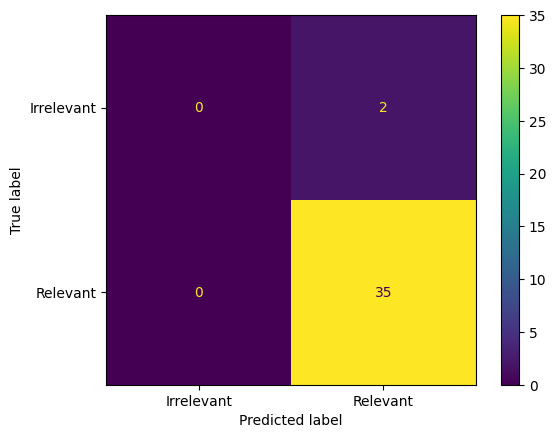

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

np_query_embeddings_eval = query_embeddings_eval.cpu().detach().numpy()
np_doc_embeddings_eval = doc_embeddings_eval.cpu().detach().numpy()
X_eval = np_query_embeddings_eval + np_doc_embeddings_eval
y_eval = dataloader.eval_dataset[:]['label']

y_pred = clf.predict(X_eval)
cm = confusion_matrix(y_eval, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Irrelevant', 'Relevant'])
print(classification_report(y_eval, y_pred))
disp.plot()

In [ ]:
import pickle

with open('./saved_models/svm/svm.pkl','wb') as f:
    pickle.dump(clf,f)